# Starting out

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!cp /content/drive/MyDrive/Kool/Ülikool/'3. aasta'/Lõputöö/data.zip .
!unzip -q data.zip
!rm data.zip

!cp /content/drive/MyDrive/Kool/Ülikool/'3. aasta'/Lõputöö/test_val.zip .
!unzip -q test_val.zip
!rm test_val.zip

In [3]:
!rm -rf line-chart-captioning/
#clone repo
!git clone https://github.com/snemvalts/line-chart-captioning
#clean out data folder and move extracted raw data to captioning
!rm -rf line-chart-captioning/data/*
!mv data/** line-chart-captioning/data/
!mv test_val/validation1 line-chart-captioning/data/figureqa/

Cloning into 'line-chart-captioning'...
remote: Enumerating objects: 152, done.
remote: Counting objects: 100% (152/152), done.
remote: Compressing objects: 100% (109/109), done.
remote: Total 152 (delta 48), reused 119 (delta 25), pack-reused 0
Receiving objects: 100% (152/152), 171.77 KiB | 14.31 MiB/s, done.
Resolving deltas: 100% (48/48), done.


In [4]:
import json

synthetic_json = {
  "questions": ["GREATER", "LESS", "INTERSECT"],
  "question_selection": {
    "GREATER": [
      "<Color1> is greater than <Color2>",
      "<Color1> is bigger than <Color2>",
      "<Color1> is larger than <Color2>",
    ],
    "LESS": [
      "<Color1> is less than <Color2>",
      "<Color1> is smaller than <Color2>"
    ],
    "INTERSECT": [
      "<Color1> intersects <Color2>"
    ]
  }
}

with open('line-chart-captioning/synthetic.json', 'w') as f:
  json.dump(synthetic_json, f)

In [5]:
!cd line-chart-captioning && \
python3 src/synthetic/preprocess.py \
--unroll-descriptions \
--replace-subjects-locally \
--synthetic-config synthetic.json \
data/figureqa/train1


parsing QA...
parsing annotations...
processing plots...
unrolling descriptions...
replacing subjects...
copying images...
writing csv...


In [6]:
!cd line-chart-captioning && \
python3 src/synthetic/preprocess.py \
--unroll-descriptions \
--replace-subjects-locally \
--synthetic-config synthetic.json \
data/figureqa/validation1

parsing QA...
parsing annotations...
processing plots...
unrolling descriptions...
replacing subjects...
copying images...
writing csv...


## creating transforms & dataset

In [7]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from PIL import Image
from skimage import transform


# adapted from https://pytorch.org/tutorials/beginner/data_loading_tutorial.html
class SyntheticImageDataset(Dataset):
  def __init__(self, csv_file, images_dir, transform=None):
    self.charts_captions = pd.read_csv(csv_file)
    self.images_dir = images_dir
    self.transform = transform

  def __len__(self):
    return len(self.charts_captions)

  def __getitem__(self, idx):
    [image_number, caption, subject_map] = self.charts_captions.iloc[idx]
    image_path = os.path.join(self.images_dir, f'{str(image_number)}.png')
    image = np.array(Image.open(image_path))
    
    sample = {'image': image, 'caption': caption, 'subject_map': subject_map }

    if self.transform:
      sample = self.transform(sample)

    return sample

In [8]:
class ResizeImage(object):
  def __init__(self, output_size):
    assert isinstance(output_size, (int, tuple))
    self.output_size = output_size

  def __call__(self, sample):
    resized_image = transform.resize(sample['image'], self.output_size)
    resized_original_image = transform.resize(sample['image'], (400, 600))
    return {**sample, 'image': resized_image, 'original_image': resized_original_image}

class StripImageTransparency(object):
  def __init__(self):
    pass

  def __call__(self, sample):
    stripped_transparency_image = sample['image'][:,:,:3]
    return {**sample, 'image': stripped_transparency_image}


class NormalizeImage(object):
  def __init__(self, mean, std):
    self.mean = mean
    self.std = std

  def __call__(self, sample):
    normalized_image = (sample['image'] - self.mean) / self.std
    return {**sample, 'image': normalized_image}


class ImageToTensor(object):
  def __init__(self):
    pass

  def __call__(self, sample):
    image = sample['image'].transpose((2, 0, 1))
    return {**sample, 'image': torch.tensor(image).float()}



# tokenize caption to list
# also adds caption lengths
class TokenizeCaption(object):
  def __init__(self):
    pass

  def __call__(self, sample):
    caption_split = sample['caption'].split(' ')
    return {**sample, 'caption': caption_split, 'caption_len': len(caption_split)}

# pad caption with <start> <end> <pad> captions
# assumes caption is tokenized
class PadCaption(object):
  def __init__(self, max_caption_len):
    self.max_caption_len = max_caption_len
    pass
  
  def __call__(self, sample):
    caption = sample['caption']
    caption_start_end = ['<start>'] + caption + ['<end>']
    # we added start and end
    max_caption_len = self.max_caption_len + 2
    pads = (max_caption_len - len(caption_start_end)) * ['<pad>']
    new_caption = caption_start_end + pads
    return {**sample, 'caption': new_caption, 'caption_len': len(new_caption)}

# transform caption to list of integers according to word map
# assumes caption is tokenized & padded
class TransformCaption(object):
  def __init__(self, word_map):
    self.word_map = word_map

  def __call__(self, sample):
    transformed_caption = list(map(lambda token: self.word_map[token], sample['caption']))
    return {**sample, 'caption': transformed_caption }

# turns caption to tensor
# assumes caption is transformed
class CaptionToTensor(object):
  def __init__(self):
    pass

  def __call__(self, sample):
    return {**sample, 'caption': torch.tensor(sample['caption']) }

In [9]:
import torch

def get_max_caption_len(csv_file):
  captions = list(pd.read_csv(csv_file)['caption'])
  sentences = [[word for word in sentence.split(' ')] for sentence in captions]
  max_caption_len = len(max(sentences, key=len))
  return max_caption_len

def get_word_map(csv_file):
  captions = list(pd.read_csv(csv_file)['caption'])
  all_words = [word for caption in captions for word in caption.split(" ")]
  unique_words = sorted(list(set(all_words)))
  # let's include the tokens that will be padded later... saves us a headache
  pad_tokens = ['<start>', '<end>', '<pad>']
  word_map = {word: i + 1 for i, word in enumerate(pad_tokens + unique_words)}
  return word_map

def get_token_map(word_map):
  return {v + 1: k for v,k in enumerate(word_map)}

def get_dataset(images_dir = None, csv_file = None):
  # parallely calculate max caption len and word map to pass it to padcaption
  # cause can't access dataset from transforms before it is defined in compose
  max_caption_len = get_max_caption_len(csv_file)
  word_map = get_word_map(csv_file)

  dataset = SyntheticImageDataset(images_dir = images_dir,
                           csv_file = csv_file,
                           transform=transforms.Compose([
                                  ResizeImage((224, 224)),
                                  StripImageTransparency(),
                                  NormalizeImage(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                                  ImageToTensor(),
                                  TokenizeCaption(),
                                  PadCaption(max_caption_len=max_caption_len),
                                  TransformCaption(word_map=word_map),
                                  CaptionToTensor()
                                 ]))

  return dataset, word_map, max_caption_len + 2


train_dataset, word_map, max_caption_len = get_dataset(images_dir = 'line-chart-captioning/data/processed_synthetic/train1/images',
                      csv_file = 'line-chart-captioning/data/processed_synthetic/train1/captions.csv')


validation_dataset = SyntheticImageDataset(images_dir = 'line-chart-captioning/data/processed_synthetic/validation1/images',
                           csv_file = 'line-chart-captioning/data/processed_synthetic/validation1/captions.csv',
                           transform=transforms.Compose([
                                  ResizeImage((224, 224)),
                                  StripImageTransparency(),
                                  NormalizeImage(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                                  ImageToTensor(),
                                  TokenizeCaption(),
                                  PadCaption(max_caption_len=max_caption_len),
                                  TransformCaption(word_map=word_map),
                                  CaptionToTensor()
                                 ]))


print(word_map, max_caption_len)
batch_size=32
validation_batch_size = 2

train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=batch_size, shuffle=True, num_workers=1, pin_memory=True)

validation_loader = torch.utils.data.DataLoader(
        validation_dataset,
        batch_size=validation_batch_size, shuffle=True, num_workers=1, pin_memory=True)


{'<start>': 1, '<end>': 2, '<pad>': 3, '<A>': 4, '<B>': 5, '<C>': 6, '<D>': 7, 'bigger': 8, 'greater': 9, 'intersects': 10, 'is': 11, 'larger': 12, 'less': 13, 'smaller': 14, 'than': 15} 7


## Encoder and decoder

In [10]:
import torchvision
from torch import nn

# Parts of model inspired by https://github.com/sgrvinod/a-PyTorch-Tutorial-to-Image-Captioning/

class Encoder(nn.Module):
  def __init__(self, encoder_output_dim = 512, trainable=False):
    super(Encoder, self).__init__()

    base_resnet = torchvision.models.resnet50(pretrained=True) 
    resnet_without_fc = nn.Sequential(*(list(base_resnet.children())[:-1]))

    # freeze weights of resnet 
    if (not trainable):
      for parameter in resnet_without_fc.parameters():
        parameter.requires_grad = False


    self.resnet = resnet_without_fc
    self.pool = nn.AdaptiveAvgPool1d(encoder_output_dim)

  
  def forward(self, x):
    x = self.resnet(x)
    x = x.squeeze().unsqueeze(1)
    x = self.pool(x).squeeze()
    return x


class FeatureAttention(nn.Module):
  def __init__(self, encoder_feature_dim, decoder_lstm_hidden_dim, attention_dim, activation='relu'):
    super(FeatureAttention, self).__init__()
    self.features_attention = nn.Linear(encoder_feature_dim, attention_dim)
    self.lstm_hidden_attention = nn.Linear(decoder_lstm_hidden_dim, attention_dim)
    self.attention = nn.Linear(attention_dim, 1)
    if (activation == 'relu'):
      self.activation = nn.ReLU()
    elif (activation == 'tanh'):
      # was in the adobe paper
      self.activation = nn.TanH()
    self.softmax = nn.Softmax(dim=1)
  
  def forward(self, encoder_features_out, decoder_lstm_hidden):
    features_attn = self.features_attention(encoder_features_out)
    decoder_attn = self.lstm_hidden_attention(decoder_lstm_hidden)
    activated = self.activation(features_attn + decoder_attn.unsqueeze(1))
    attention = self.softmax(self.attention(activated))
    attention_weighted_features = (encoder_features_out * attention).sum(dim=1)

    return attention_weighted_features


# Currently unused
class RelationAttention(nn.Module):
  def __init__(self, encoder_feature_dim, decoder_lstm_hidden_dim, attention_dim, mlp_dim, activation='relu'):
    super(RelationAttention, self).__init__()
    # with 512 encoder_feature_dim
    feature_pair_vectors_dim = 2

    self.mlp_input = nn.Linear(feature_pair_vectors_dim, mlp_dim)
    self.mlp_hidden_1 = nn.Linear(mlp_dim, mlp_dim)
    self.mlp_hidden_2 = nn.Linear(mlp_dim, mlp_dim)
    self.mlp_activation = nn.ReLU()
    self.mlp_output = nn.Linear(mlp_dim, feature_pair_vectors_dim)

    self.relations_attention = nn.Linear(feature_pair_vectors_dim, attention_dim)
    self.lstm_hidden_attention = nn.Linear(decoder_lstm_hidden_dim, attention_dim)
    self.attention = nn.Linear(attention_dim, 1)
    if (activation == 'relu'):
      self.activation = nn.ReLU()
    elif (activation == 'tanh'):
      # was in the adobe paper
      self.activation = nn.TanH()
    self.softmax = nn.Softmax(dim=1)
  


  def forward(self, encoder_features_out, decoder_lstm_hidden):
    combinations = torch.cat([torch.combinations(features).unsqueeze(0) for features in debug_tensor])

    mlp_x = self.mlp_input(combinations)
    mlp_x = self.mlp_hidden_1(mlp_x)
    mlp_x = self.mlp_hidden_2(mlp_x)
    mlp_y = self.mlp_activation(self.mlp_output(mlp_x))

    relations_attn = self.relations_attention(mlp_y)
    decoder_attn = self.lstm_hidden_attention(decoder_lstm_hidden)

    activated = self.activation(relations_attn + decoder_attn.unsqueeze(1))
    attention = self.softmax(self.attention(activated))
    attention_weighted_features = (encoder_features_out * attention).sum(dim=1)

    return attention_weighted_features


class DecoderWithAttentions(nn.Module):
  def __init__(self, embedding_dim, 
               decoder_dim, 
               vocabulary_size,
               feature_attention_dim,
               relation_attention_dim,
               encoder_dim=512, 
               mlp_dim = 128,
               dropout_p=0.5):
    super(DecoderWithAttentions, self).__init__()
    self.encoder_dim = encoder_dim
    self.attention_dim = attention_dim
    self.embedding_dim = embedding_dim
    self.decoder_dim = decoder_dim
    self.vocabulary_size = vocabulary_size

    self.features_attention = FeatureAttention(encoder_dim, decoder_dim, feature_attention_dim)
    self.relations_attention = RelationAttention(encoder_dim, decoder_dim, relation_attention_dim, mlp_dim)

    self.embedding = nn.Embedding(vocabulary_size, embedding_dim)
    self.dropout = nn.Dropout(p=dropout_p)

    # To do teacher forcing, uncomment this, embedding layer definition, and embedding concat layer
    self.decoder_lstm = nn.LSTMCell(encoder_dim+embedding_dim, decoder_dim, bias=True)
    #self.decoder_lstm = nn.LSTMCell(2068, decoder_dim, bias=True)

    self.init_h = nn.Linear(encoder_dim, decoder_dim)
    self.init_c = nn.Linear(encoder_dim, decoder_dim)
    self.forget_gate = nn.Linear(decoder_dim, encoder_dim)

    self.output = nn.Linear(decoder_dim, vocab_size)
    self.sigmoid = nn.Sigmoid()
    self.softmax = nn.Softmax()

    self.init_weights()

  def init_weights(self):
    self.embedding.weight.data.uniform_(-0.1, 0.1)
    self.output.bias.data.fill_(0)
    self.output.weight.data.uniform_(-0.1, 0.1)


  def init_hidden_state(self, encoder_out):
    mean_encoder_out = encoder_out.mean(dim=1).unsqueeze(1).repeat(1, self.encoder_dim)
    h = self.init_h(mean_encoder_out)
    c = self.init_c(mean_encoder_out)
    return h, c


  def forward(self, encoder_out, embedding_captions):
    batch_size = encoder_out.size(0)
    encoder_dim = encoder_out.size(-1)


    embeddings = self.embedding(embedding_captions)

    h, c = self.init_hidden_state(encoder_out)

    predictions = torch.zeros(batch_size, max_caption_len, vocab_size).to(device)

    # iterate until all tokens have been generated
    for t in range(max_caption_len):
      feature_attention = self.features_attention(encoder_out, h)

      context_vector = feature_attention #torch.cat((feature_attention, relations_attention))
      forget_gate = self.sigmoid(self.forget_gate(h))

      context_vector = forget_gate * context_vector


      lstm_input = torch.cat([embeddings[:, t, :], context_vector], dim=1)
      #lstm_input = torch.cat([predictions[:, t - 1, :], context_vector], dim=1)

      h, c = self.decoder_lstm(lstm_input, (h, c))
        
      predicted_tokens = self.softmax(self.output(self.dropout(h)))
      predictions[:, t, :] = predicted_tokens

    return predictions

In [11]:
# from https://github.com/sgrvinod/a-PyTorch-Tutorial-to-Image-Captioning/
def accuracy(scores, targets, k):
    """
    Computes top-k accuracy, from predicted and true labels.
    :param scores: scores from the model
    :param targets: true labels
    :param k: k in top-k accuracy
    :return: top-k accuracy
    """
    scores = scores.view(1, -1, *(scores.size()[2:])).squeeze()
    targets = targets.view(1, -1, *(targets.size()[2:])).squeeze()

    batch_size = targets.size(0)
    _, ind = scores.topk(k, 1, True, True)
    correct = ind.eq(targets.view(-1, 1).expand_as(ind))
    correct_total = correct.view(-1).float().sum()  # 0D tensor
    return correct_total.item() * (100.0 / batch_size)

In [15]:
from torch.nn.utils.rnn import pack_padded_sequence
from nltk.translate.bleu_score import corpus_bleu
import random
import gc

torch.cuda.empty_cache()
gc.collect()

def get_caption_from_transformed(prediction, token_map):
  return [[token_map[token] if token in token_map else '?' for token in tokens] for tokens in prediction]

def strip_start_end_pad(prediction):
  return [list(filter(lambda token: token != '<start>' and token != '<end>' and token != '<pad>', tokens)) for tokens in prediction]

def get_ground_truth_captions(ground_truth_transformed_captions, token_map):
  ground_truth_captions_padded = get_caption_from_transformed(ground_truth_transformed_captions, token_map)

  ground_truth_captions = []

  for caption in ground_truth_captions_padded:
    new_caption = list(filter(lambda x : x != '<start>' and x != '<end>' and x != '<pad>', caption))
    ground_truth_captions.append(new_caption)

  return ground_truth_captions


def train_epoch(encoder_dim, decoder_dim, attention_dim, embed_dim, vocab_size, iter_cap=300):
  global min_loss
  iter_without_improvement = 0

  for i, batch in enumerate(train_loader):
    imgs = batch['image'].to(device)
    target_caps = batch['caption'].to(device)

    imgs = encoder(imgs)
    prediction_scores = decoder(imgs, target_caps)

    # Calculate loss
    loss = criterion(prediction_scores.permute(0,2,1), target_caps)

    decoder_optimizer.zero_grad()
    loss.backward()
    decoder_optimizer.step()

    #encoder_optimizer.zero_grad()
    #encoder_optimizer.step()

    loss_score = loss.cpu().detach().numpy()

    if (loss_score <= min_loss):
      min_loss = loss_score
      iter_without_improvement = 0
    else:
      iter_without_improvement += 1

    predicted_captions = torch.argmax(prediction_scores, dim=2).cpu().numpy()

    hypotheses = strip_start_end_pad(get_caption_from_transformed(predicted_captions, token_map))
    ground_truth_transformed = batch['caption'].cpu().numpy()
    ground_truth_captions = get_ground_truth_captions(ground_truth_transformed, token_map)

    ground_truth_captions_bleu = [[caption] for caption in ground_truth_captions]
    bleu_score = corpus_bleu(ground_truth_captions_bleu, hypotheses)
    accuracy_score = accuracy(prediction_scores, target_caps, 2)

    print(f"Batch #{i}/{len(train_loader)}: BLEU is {bleu_score:.2f}, loss is {loss_score:.3f}, top-2 accuracy is {accuracy_score:.1f}%")
    rand_i = random.randint(0, batch_size - 1)

    try:
      print("random prediction: ", hypotheses[rand_i])
      print("and the corresponding caption: ", ground_truth_captions[rand_i])
    except IndexError:
      pass

    #if (iter_without_improvement >= iter_cap):
    #  print(f"{iter_cap} iterations without improvement. stopping")
    #  break




encoder_dim = 2048
decoder_dim = 1024
attention_dim = 1024
embed_dim = 256
vocab_size = 20
decoder_lr = 1e-4
#encoder_lr = 1e-4

epochs = 5

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

encoder = Encoder(encoder_output_dim=encoder_dim, trainable=True).to(device)
#encoder_optimizer = torch.optim.Adam(params=filter(lambda p: p.requires_grad, encoder.parameters()),
#                                             lr=encoder_lr)

decoder = DecoderWithAttentions(embed_dim, 
                                decoder_dim, 
                                vocab_size, 
                                attention_dim, 
                                attention_dim, 
                                encoder_dim=encoder_dim
                                ).to(device)
decoder_optimizer = torch.optim.Adam(params=filter(lambda p: p.requires_grad, decoder.parameters()),
                                             lr=decoder_lr)

criterion = nn.CrossEntropyLoss().to(device)
token_map = get_token_map(word_map)

min_loss = float('inf')
iter_without_improvement = 0

decoder.train()

for epoch in range(epochs):
  print(f"Epoch {epoch + 1} of {epochs}")
  train_epoch(encoder_dim, decoder_dim, attention_dim, embed_dim, vocab_size)

Epoch 1 of 5


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:171: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


Batch #0/1433: BLEU is 0.17, loss is 2.998, top-2 accuracy is 3.1%
random prediction:  ['?', '?', '?', '?', '<D>']
and the corresponding caption:  ['<A>', 'is', 'smaller', 'than', '<B>']


/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


Batch #1/1433: BLEU is 0.00, loss is 2.953, top-2 accuracy is 40.6%
random prediction:  []
and the corresponding caption:  ['<B>', 'is', 'smaller', 'than', '<A>']
Batch #2/1433: BLEU is 0.00, loss is 2.869, top-2 accuracy is 35.7%
random prediction:  []
and the corresponding caption:  ['<B>', 'intersects', '<A>']
Batch #3/1433: BLEU is 0.00, loss is 2.821, top-2 accuracy is 32.6%
random prediction:  []
and the corresponding caption:  ['<B>', 'is', 'smaller', 'than', '<A>']
Batch #4/1433: BLEU is 0.00, loss is 2.789, top-2 accuracy is 37.1%
random prediction:  []
and the corresponding caption:  ['<A>', 'is', 'larger', 'than', '<B>']
Batch #5/1433: BLEU is 0.00, loss is 2.782, top-2 accuracy is 36.2%
random prediction:  []
and the corresponding caption:  ['<B>', 'intersects', '<A>']
Batch #6/1433: BLEU is 0.00, loss is 2.781, top-2 accuracy is 37.9%
random prediction:  []
and the corresponding caption:  ['<A>', 'is', 'smaller', 'than', '<B>']
Batch #7/1433: BLEU is 0.00, loss is 2.780, t

KeyboardInterrupt: ignored

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:171: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


['<start>', '<B>', '<end>', '<B>', '<end>', '<pad>', '<pad>']


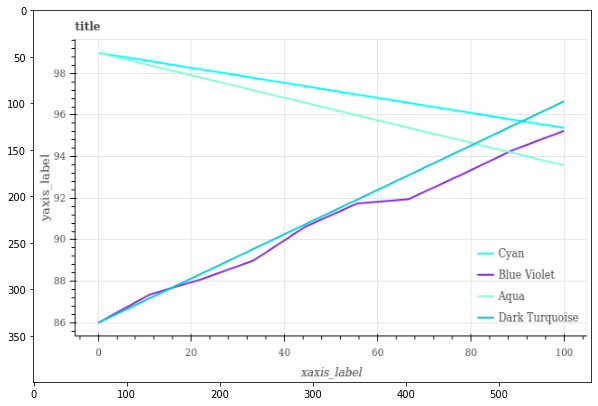

In [16]:
import gc
import matplotlib.pyplot as plt


torch.cuda.empty_cache()
gc.collect()


previous_captions = torch.ones(validation_batch_size, max_caption_len) * 10
previous_captions = previous_captions.type(torch.LongTensor).to(device)

def infer_next_validation_image():
  global previous_captions
  with torch.no_grad():
    batch = next(iter(validation_loader))
    imgs = batch['image'].to(device)
    encoded_imgs = encoder(imgs)

    prediction_scores = decoder(encoded_imgs, previous_captions)

    predicted_captions = torch.argmax(prediction_scores, dim=2).cpu().numpy()
    previous_captions = predicted_captions

    hypotheses = get_caption_from_transformed(predicted_captions, token_map)
    ground_truth_transformed = batch['caption'].cpu().numpy()
    ground_truth_captions = get_ground_truth_captions(ground_truth_transformed, token_map)
    plt.figure(figsize = (10, 10))
    plt.imshow(batch['original_image'][0])


    print(hypotheses[0])

infer_next_validation_image()

## saving logic

In [ ]:
import datetime
date_str = datetime.datetime.now().replace(microsecond=0).isoformat()

lstm_decoder_model_name = f'lstm_decoder_{date_str}_state.pth'

torch.save(decoder.state_dict(), f"/content/drive/MyDrive/Kool/Ülikool/3. aasta/Lõputöö/{lstm_decoder_model_name}")
